## Skeleton Code

The code below provides a skeleton for the model building & training component of your project. You can add/remove/build on code however you see fit, this is meant as a starting point.

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from glob import glob
%matplotlib inline
import matplotlib.pyplot as plt

##Import any other stats/DL/ML packages you may need here. E.g. Keras, scikit-learn, etc.
import sklearn.model_selection as skl
from random import sample 
from keras.preprocessing.image import ImageDataGenerator

from keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten, Conv2D, MaxPooling2D,AveragePooling2D
from keras.models import Sequential, Model, model_from_json
from keras.applications.vgg16 import VGG16
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping

from sklearn.metrics import roc_curve, auc, precision_recall_curve
from sklearn.metrics import average_precision_score, plot_precision_recall_curve, f1_score, confusion_matrix, accuracy_score
import pydicom
import time

Using TensorFlow backend.


In [2]:
start=time.time()

## Do some early processing of your metadata for easier model training:

In [3]:
## Below is some helper code to read all of your full image filepaths into a dataframe for easier manipulation
## Load the NIH data to all_xray_df
all_xray_df = pd.read_csv('/data/Data_Entry_2017.csv')
all_image_paths = {os.path.basename(x): x for x in 
                   glob(os.path.join('/data','images*', '*', '*.png'))}
print('Scans found:', len(all_image_paths), ', Total Headers', all_xray_df.shape[0])
all_xray_df['path'] = all_xray_df['Image Index'].map(all_image_paths.get)
all_xray_df.sample(3)

Scans found: 112120 , Total Headers 112120


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11,path
2306,00000591_015.png,Effusion,15,591,65,M,PA,2992,2991,0.143,0.143,NaN,/data/images_001/images/00000591_015.png
104272,00027857_000.png,No Finding,0,27857,31,F,PA,2538,2409,0.143,0.143,NaN,/data/images_011/images/00027857_000.png
99645,00026392_002.png,No Finding,2,26392,21,M,PA,2992,2991,0.143,0.143,NaN,/data/images_011/images/00026392_002.png


In [4]:
all_xray_df

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11,path
0,00000001_000.png,Cardiomegaly,0,1,58,M,PA,2682,2749,0.143,0.143,NaN,/data/images_001/images/00000001_000.png
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA,2894,2729,0.143,0.143,NaN,/data/images_001/images/00000001_001.png
2,00000001_002.png,Cardiomegaly|Effusion,2,1,58,M,PA,2500,2048,0.168,0.168,NaN,/data/images_001/images/00000001_002.png
3,00000002_000.png,No Finding,0,2,81,M,PA,2500,2048,0.171,0.171,NaN,/data/images_001/images/00000002_000.png
4,00000003_000.png,Hernia,0,3,81,F,PA,2582,2991,0.143,0.143,NaN,/data/images_001/images/00000003_000.png
...,...,...,...,...,...,...,...,...,...,...,...,...,...
112115,00030801_001.png,Mass|Pneumonia,1,30801,39,M,PA,2048,2500,0.168,0.168,NaN,/data/images_012/images/00030801_001.png
112116,00030802_000.png,No Finding,0,30802,29,M,PA,2048,2500,0.168,0.168,NaN,/data/images_012/images/00030802_000.png
112117,00030803_000.png,No Finding,0,30803,42,F,PA,2048,2500,0.168,0.168,NaN,/data/images_012/images/00030803_000.png
112118,00030804_000.png,No Finding,0,30804,30,F,PA,2048,2500,0.168,0.168,NaN,/data/images_012/images/00030804_000.png


In [5]:
## Here you may want to create some extra columns in your table with binary indicators of certain diseases 
## rather than working directly with the 'Finding Labels' column

# Todo - Copied from EDA file

#Drop columns with NA
all_xray_df.drop(columns=['Unnamed: 11'], inplace=True)

del_age=all_xray_df[all_xray_df['Patient Age'] > 100].index.tolist()
all_xray_df.drop(index=del_age,  inplace=True)

labels=all_xray_df['Finding Labels'].tolist()
labelsnew=[]
for i in labels:
    elem=i.split('|')
    for j in elem:
        labelsnew.append(j)
labelsnew=np.unique(labelsnew).tolist()

for i in labelsnew:
    all_xray_df[i]=0
    
all_xray_df.index = range(len(all_xray_df)) #Change indexing - Otherwise problem with the loop below
for ind,val in enumerate(all_xray_df['Finding Labels']):
    for j in labelsnew:
        if j in val:
            all_xray_df.at[ind,j]=1
all_xray_df

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,...,Emphysema,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
0,00000001_000.png,Cardiomegaly,0,1,58,M,PA,2682,2749,0.143,...,0,0,0,0,0,0,0,0,0,0
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA,2894,2729,0.143,...,1,0,0,0,0,0,0,0,0,0
2,00000001_002.png,Cardiomegaly|Effusion,2,1,58,M,PA,2500,2048,0.168,...,0,0,0,0,0,0,0,0,0,0
3,00000002_000.png,No Finding,0,2,81,M,PA,2500,2048,0.171,...,0,0,0,0,0,1,0,0,0,0
4,00000003_000.png,Hernia,0,3,81,F,PA,2582,2991,0.143,...,0,0,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
112099,00030801_001.png,Mass|Pneumonia,1,30801,39,M,PA,2048,2500,0.168,...,0,0,0,0,1,0,0,0,1,0
112100,00030802_000.png,No Finding,0,30802,29,M,PA,2048,2500,0.168,...,0,0,0,0,0,1,0,0,0,0
112101,00030803_000.png,No Finding,0,30803,42,F,PA,2048,2500,0.168,...,0,0,0,0,0,1,0,0,0,0
112102,00030804_000.png,No Finding,0,30804,30,F,PA,2048,2500,0.168,...,0,0,0,0,0,1,0,0,0,0


In [6]:
print("Number of images with pneumonia: {}".format(sum(all_xray_df['Pneumonia'] == 1)))
print("Number of images without pneumonia: {}".format(sum(all_xray_df['Pneumonia'] == 0)))

Number of images with pneumonia: 1430
Number of images without pneumonia: 110674


In [7]:
## Here we can create a new column called 'pneumonia_class' that will allow us to look at 
## images with or without pneumonia for binary classification

# Todo
#Done above

## Create your training and testing data:

In [8]:
def create_splits(data, test_size, param ):
    
    ## Either build your own or use a built-in library to split your original dataframe into two sets 
    ## that can be used for training and testing your model
    ## It's important to consider here how balanced or imbalanced you want each of those sets to be
    ## for the presence of pneumonia
    
    # Todo
    train_data, val_data = skl.train_test_split(data, 
                                   test_size = test_size, random_state=16,
                                   stratify = data[param])
    
    return train_data, val_data

In [9]:
train_df,valid_df=create_splits(all_xray_df, 0.2, "Pneumonia") # 80% of data for train and 20% for validation
#We assume that the distribution of all other parameters is preserved. We confirm that for gender as shown below

#we want our model to be trained on a set that has equal proportions of pneumonia and no pneumonia,
#so we're going to have to throw away some data:
p_inds = train_df[train_df.Pneumonia==1].index.tolist()
np_inds = train_df[train_df.Pneumonia==0].index.tolist()

np_sample = sample(np_inds,len(p_inds))
train_df = train_df.loc[p_inds + np_sample]
train_df['Pneumonia'].sum()/len(train_df)

0.5

In [10]:
valid_df['Pneumonia'].sum()/len(valid_df)

0.01275589848802462

In [11]:
all_xray_df['Pneumonia'].sum()/len(all_xray_df)

0.012756012274316705

In [12]:
# we want to make the balance in our validation set more like 20-80 
# since we assume that the prevalence of Pneumonia in this clinical situation is about 20%
p_inds = valid_df[valid_df.Pneumonia==1].index.tolist()
np_inds = valid_df[valid_df.Pneumonia==0].index.tolist()

# The following code pulls a random sample of non-pneumonia data that's 4 times as big as the pneumonia sample.
np_sample = sample(np_inds,4*len(p_inds))
valid_df = valid_df.loc[p_inds + np_sample]
valid_df['Pneumonia'].sum()/len(valid_df)

0.2

In [13]:
print(train_df.shape)
print(valid_df.shape)

(2288, 27)
(1430, 27)


In [14]:
sum(train_df.Pneumonia==1)

1144

In [15]:
sum(valid_df.Pneumonia==1)

286

In [16]:
all_xray_df[all_xray_df.Pneumonia == 1]['Patient Gender'].value_counts(normalize=True)

M    0.585315
F    0.414685
Name: Patient Gender, dtype: float64

In [17]:
train_df[train_df.Pneumonia == 1]['Patient Gender'].value_counts(normalize=True)

M    0.592657
F    0.407343
Name: Patient Gender, dtype: float64

In [18]:
valid_df[valid_df.Pneumonia == 1]['Patient Gender'].value_counts(normalize=True)

M    0.555944
F    0.444056
Name: Patient Gender, dtype: float64

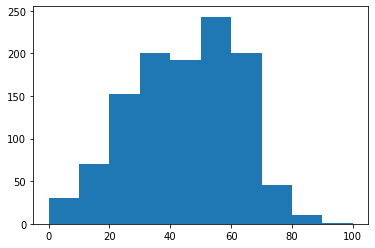

In [26]:
plt.hist(train_df[train_df.Pneumonia == 1]['Patient Age'],range=[0, 100], bins=10)
plt.savefig("trainage")

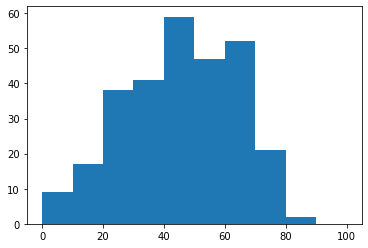

In [27]:
plt.hist(valid_df[valid_df.Pneumonia == 1]['Patient Age'],range=[0, 100], bins=10)
plt.savefig("validage")

In [21]:
(train_df[labelsnew].sum()/len(train_df)).nlargest(20)

Pneumonia             0.500000
Infiltration          0.293706
No Finding            0.265734
Effusion              0.155594
Atelectasis           0.142483
Edema                 0.124563
Consolidation         0.067745
Nodule                0.055070
Mass                  0.052885
Pneumothorax          0.041521
Pleural_Thickening    0.031469
Cardiomegaly          0.024913
Emphysema             0.019231
Fibrosis              0.013986
Hernia                0.001311
dtype: float64

In [22]:
(valid_df[labelsnew].sum()/len(valid_df)).nlargest(20)

No Finding            0.457343
Infiltration          0.209091
Pneumonia             0.200000
Effusion              0.119580
Atelectasis           0.106993
Edema                 0.059441
Nodule                0.052448
Mass                  0.047552
Consolidation         0.045455
Pneumothorax          0.031469
Cardiomegaly          0.025874
Emphysema             0.025874
Pleural_Thickening    0.025874
Fibrosis              0.015385
Hernia                0.001399
dtype: float64

Even though the distribution of genders is a little bit different than expected, this will not create any problems in training.

# Now we can begin our model-building & training

#### First suggestion: perform some image augmentation on your data

In [18]:
def my_image_augmentation(horizontal_flip = False, vertical_flip = False, height_shift_range= 0, width_shift_range=0, 
                              rotation_range=0, shear_range = 0, zoom_range=0):
    
    ## recommendation here to implement a package like Keras' ImageDataGenerator
    ## with some of the built-in augmentations 
    
    ## keep an eye out for types of augmentation that are or are not appropriate for medical imaging data
    ## Also keep in mind what sort of augmentation is or is not appropriate for testing vs validation data
    
    ## STAND-OUT SUGGESTION: implement some of your own custom augmentation that's *not*
    ## built into something like a Keras package
    
    # Todo
    #rescale=1. / 255.0, 
    my_idg = ImageDataGenerator(samplewise_center=True, samplewise_std_normalization=True,
                              horizontal_flip = horizontal_flip, 
                              vertical_flip = vertical_flip, 
                              height_shift_range= height_shift_range, 
                              width_shift_range=width_shift_range, 
                              rotation_range=rotation_range, 
                              shear_range = shear_range,
                              zoom_range=zoom_range)
    
    return my_idg


def make_train_gen(traingen, train_df, x_col ,y_col,target_size , batch_size):
    
    ## Create the actual generators using the output of my_image_augmentation for your training data
    ## Suggestion here to use the flow_from_dataframe library, e.g.:
    
#     train_gen = my_train_idg.flow_from_dataframe(dataframe=train_df, 
#                                          directory=None, 
#                                          x_col = ,
#                                          y_col = ,
#                                          class_mode = 'binary',
#                                          target_size = , 
#                                          batch_size = 
#                                          )
     # Todo
    
    train_gen = traingen.flow_from_dataframe(dataframe=train_df, 
                                         directory=None, 
                                         x_col = x_col,
                                         y_col = y_col,
                                         class_mode = 'binary',
                                         target_size = target_size, 
                                         batch_size = batch_size
                                         )

    return train_gen


def make_val_gen(valaug, val_df, x_col ,y_col,target_size , batch_size):
    
#     val_gen = my_val_idg.flow_from_dataframe(dataframe = val_data, 
#                                              directory=None, 
#                                              x_col = ,
#                                              y_col = ',
#                                              class_mode = 'binary',
#                                              target_size = , 
#                                              batch_size = ) 
    
    # Todo
    
    val_gen = valaug.flow_from_dataframe(dataframe=val_df, 
                                         directory=None, 
                                         x_col = x_col,
                                         y_col = y_col,
                                         class_mode = 'binary',
                                         target_size = target_size, 
                                         batch_size = batch_size) ## We've only been provided with 6 validation images
    return val_gen

In [19]:
#We make pneumonia columns strings - Otherwise error in the generator
train_df['Pneumonia'] = train_df['Pneumonia'].astype('str')
valid_df['Pneumonia'] = valid_df['Pneumonia'].astype('str')

In [20]:
trainaug=my_image_augmentation(horizontal_flip = True, vertical_flip = False, height_shift_range= 0.1, width_shift_range=0.1, rotation_range=20, shear_range = 0.1, zoom_range=0.1)
train_gen=make_train_gen(trainaug, train_df, x_col = 'path', y_col = 'Pneumonia', target_size = (224,224), 
                        batch_size = 32)#16

valaug=my_image_augmentation()

val_gen=make_val_gen(valaug, valid_df, x_col = 'path', y_col = 'Pneumonia', target_size = (224,224), 
                        batch_size = 32)#13

Found 2288 validated image filenames belonging to 2 classes.
Found 1430 validated image filenames belonging to 2 classes.


In [21]:
## May want to pull a single large batch of random validation data for testing after each epoch:
valX, valY = val_gen.next()

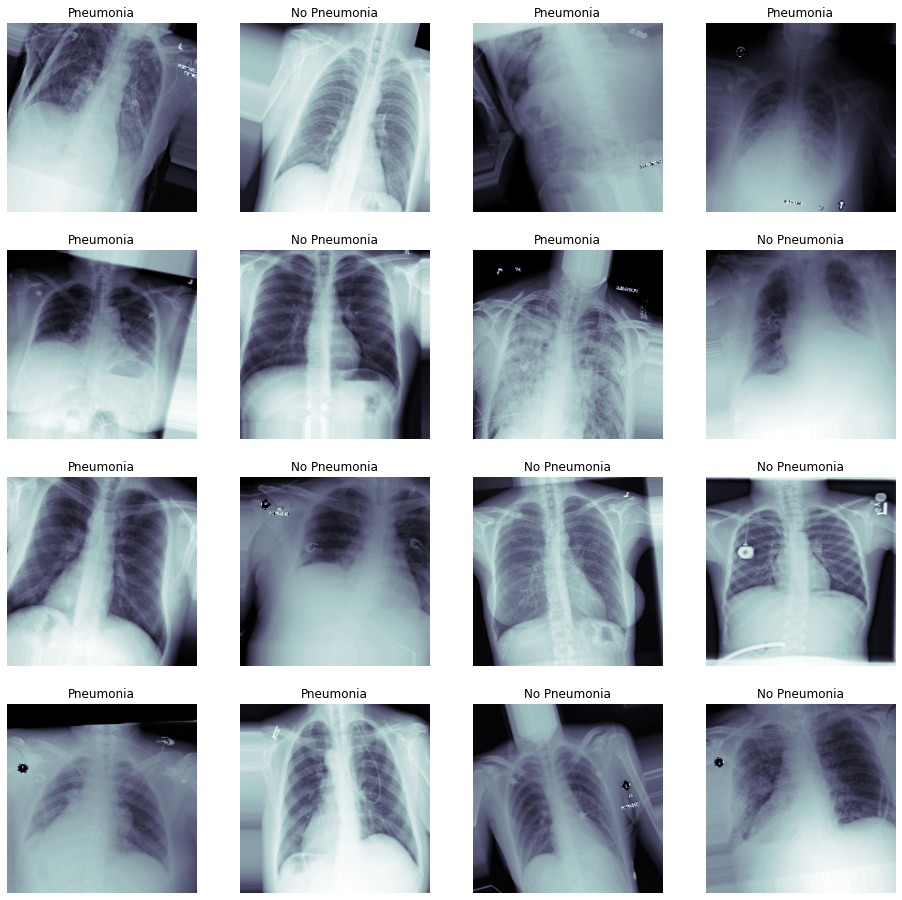

In [22]:
## May want to look at some examples of our augmented training data. 
## This is helpful for understanding the extent to which data is being manipulated prior to training, 
## and can be compared with how the raw data look prior to augmentation

t_x, t_y = next(train_gen)
fig, m_axs = plt.subplots(4, 4, figsize = (16, 16))
for (c_x, c_y, c_ax) in zip(t_x, t_y, m_axs.flatten()):
    c_ax.imshow(c_x[:,:,0], cmap = 'bone')
    if c_y == 1: 
        c_ax.set_title('Pneumonia')
    else:
        c_ax.set_title('No Pneumonia')
    c_ax.axis('off')
plt.savefig('examples.png')

## Build your model: 

Recommendation here to use a pre-trained network downloaded from Keras for fine-tuning

In [61]:
#Load model to omit the sections below
json_file = open('my_model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()

loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("best_my_model.best.hdf5")
my_model=loaded_model
print("Loaded model from disk")

Loaded model from disk


In [23]:
def load_pretrained_model(layer_of_interest='block5_pool'):
    
    # model = VGG16(include_top=True, weights='imagenet')
    # transfer_layer = model.get_layer(lay_of_interest)
    # vgg_model = Model(inputs = model.input, outputs = transfer_layer.output)
    
    # Todo
    model = VGG16(include_top=True, weights='imagenet')
    transfer_layer = model.get_layer(layer_of_interest)
    vgg_model = Model(inputs=model.input,
                   outputs=transfer_layer.output)
    for layer in vgg_model.layers[0:17]:
        layer.trainable = False

    return vgg_model

In [24]:
vgg_model=load_pretrained_model()
vgg_model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0   

In [25]:
def build_my_model(model=vgg_model):
    
    # my_model = Sequential()
    # ....add your pre-trained model, and then whatever additional layers you think you might
    # want for fine-tuning (Flatteen, Dense, Dropout, etc.)
    
    # if you want to compile your model within this function, consider which layers of your pre-trained model, 
    # you want to freeze before you compile 
    
    # also make sure you set your optimizer, loss function, and metrics to monitor
    
    # Todo
    my_model=Sequential()
    my_model.add(model)

    my_model.add(AveragePooling2D(pool_size=(4, 4)))
    my_model.add(Flatten())
    my_model.add(Dense(64, activation="relu"))
    my_model.add(Dropout(0.5))


#     # Add a dropout-layer which may prevent overfitting and
#     # improve generalization ability to unseen data e.g. the test-set.
#     my_model.add(Dropout(0.5))

#     # Add a dense (aka. fully-connected) layer.
#     # This is for combining features that the VGG16 model has
#     # recognized in the image.
#     my_model.add(Dense(1024, activation='relu'))

#     # Add a dropout-layer which may prevent overfitting and
#     # improve generalization ability to unseen data e.g. the test-set.
#     my_model.add(Dropout(0.5))

#     # Add a dense (aka. fully-connected) layer.
#     # This is for combining features that the VGG16 model has
#     # recognized in the image.
#     my_model.add(Dense(512, activation='relu'))

#     # Add a dropout-layer which may prevent overfitting and
#     # improve generalization ability to unseen data e.g. the test-set.
#     my_model.add(Dropout(0.5))

#     # Add a dense (aka. fully-connected) layer.
#     # This is for combining features that the VGG16 model has
#     # recognized in the image.
#     my_model.add(Dense(256, activation='relu'))

    # Add a dense (aka. fully-connected) layer.
    # Change the activation function to sigmoid 
    # so output of the last layer is in the range of [0,1] 
    my_model.add(Dense(1, activation='sigmoid'))


    return my_model

## STAND-OUT Suggestion: choose another output layer besides just the last classification layer of your modele
## to output class activation maps to aid in clinical interpretation of your model's results

In [26]:
lr=0.0001
my_model=build_my_model()
optimizer = Adam(lr=lr)#-3?
loss = 'binary_crossentropy' #same as log loss
metrics = ['accuracy'] #binary_accuracy
my_model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

In [27]:
# my_model=build_my_model(vgg_model)
my_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model_1 (Model)              (None, 7, 7, 512)         14714688  
_________________________________________________________________
average_pooling2d_1 (Average (None, 1, 1, 512)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                32832     
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 14,747,585
Trainable params: 2,392,705
Non-trainable params: 12,354,880
__________________________________

In [28]:
## Below is some helper code that will allow you to add checkpoints to your model,
## This will save the 'best' version of your model by comparing it to previous epochs of training

## Note that you need to choose which metric to monitor for your model's 'best' performance if using this code. 
## The 'patience' parameter is set to 10, meaning that your model will train for ten epochs without seeing
## improvement before quitting

# Todo

weight_path="best_my_model.best.hdf5"

checkpoint = ModelCheckpoint(weight_path, 
                             monitor= "val_loss", 
                             verbose=1, 
                             save_best_only=True, 
                             mode= 'min', 
                             save_weights_only = True)


def step_decay(epoch):
# initialize the base initial learning rate, drop factor, and
# epochs to drop every
    initAlpha = lr
    factor = 0.25
    dropEvery = 5

    # compute learning rate for the current epoch
    alpha = initAlpha * (factor ** np.floor((1 + epoch) / dropEvery))

    # return the learning rate
    return float(alpha)

callbacks_list = [checkpoint, LearningRateScheduler(step_decay)]

### Start training! 

In [29]:
## train your model

# Todo

history = my_model.fit_generator(train_gen, 
                          validation_data = (valX, valY), 
                          epochs = 25, 
                          callbacks = callbacks_list, verbose=True)

Epoch 1/25
72/72 [==============================] - 61s 850ms/step - loss: 0.6922 - accuracy: 0.5490 - val_loss: 0.6345 - val_accuracy: 0.7500

Epoch 00001: val_loss improved from inf to 0.63446, saving model to best_my_model.best.hdf5
Epoch 2/25
72/72 [==============================] - 58s 807ms/step - loss: 0.6792 - accuracy: 0.5726 - val_loss: 0.6111 - val_accuracy: 0.7812

Epoch 00002: val_loss improved from 0.63446 to 0.61110, saving model to best_my_model.best.hdf5
Epoch 3/25
72/72 [==============================] - 58s 810ms/step - loss: 0.6673 - accuracy: 0.5966 - val_loss: 0.6955 - val_accuracy: 0.5312

Epoch 00003: val_loss did not improve from 0.61110
Epoch 4/25
72/72 [==============================] - 58s 800ms/step - loss: 0.6586 - accuracy: 0.6158 - val_loss: 0.4337 - val_accuracy: 0.8750

Epoch 00004: val_loss improved from 0.61110 to 0.43372, saving model to best_my_model.best.hdf5
Epoch 5/25
72/72 [==============================] - 58s 810ms/step - loss: 0.6574 - accur

##### After training for some time, look at the performance of your model by plotting some performance statistics:

Note, these figures will come in handy for your FDA documentation later in the project

In [30]:
end=time.time()
print(end-start)

1495.5565786361694


In [31]:
#Save history as dictionary
import pickle

with open('histodict', 'wb') as file_pi:
    pickle.dump(history.history, file_pi)

In [32]:
with open(r"histodict", "rb") as input_file:
      past = pickle.load(input_file)
past['val_loss']

[0.6344645023345947,
 0.611100435256958,
 0.6954666376113892,
 0.43372297286987305,
 0.5781574249267578,
 0.5851081609725952,
 0.5597925782203674,
 0.5240640640258789,
 0.6062521934509277,
 0.5738650560379028,
 0.5767916440963745,
 0.5814939737319946,
 0.5610125660896301,
 0.5725188851356506,
 0.5796908736228943,
 0.5730430483818054,
 0.5831059217453003,
 0.5802311301231384,
 0.578208863735199,
 0.5785032510757446,
 0.5762972235679626,
 0.5764780044555664,
 0.5741179585456848,
 0.5749284625053406,
 0.574966311454773]

In [33]:
## Just save model architecture to a .json:
# my_model.save("my_model")
model_json = my_model.to_json()
with open("my_model.json", "w") as json_file:
    json_file.write(model_json)

In [34]:
## After training, make some predictions to assess your model's overall performance
## Note that detecting pneumonia is hard even for trained expert radiologists, 
## so there is no need to make the model perfect.

val_gen = make_val_gen(valaug, valid_df, x_col = 'path', y_col = 'Pneumonia', target_size = (224,224), batch_size=1430)
valX, valY = val_gen.next()

pred_Y = my_model.predict(valX,  verbose = True)#batch_size = 13,

Found 1430 validated image filenames belonging to 2 classes.
1430/1430 [==============================] - 15s 11ms/step


In [35]:
pred_Y

array([[0.5253568 ],
       [0.45454046],
       [0.4110783 ],
       ...,
       [0.30700788],
       [0.50734556],
       [0.56965464]], dtype=float32)

In [36]:
pred_Y_bin = [1 if i[0] > 0.5 else 0 for i in pred_Y]
pred_Y_bin

[1,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 1,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 1,


In [37]:
valY

array([0., 0., 0., ..., 0., 0., 0.], dtype=float32)

In [38]:
def plot_auc(t_y, p_y):
    
    ## Hint: can use scikit-learn's built in functions here like roc_curve
    
    # Todo
    fig, c_ax = plt.subplots(1,1, figsize = (9, 9))
    fpr, tpr, thresholds = roc_curve(t_y, p_y)
    c_ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % ('Pneumonia', auc(fpr, tpr)))
    c_ax.legend()
    c_ax.set_xlabel('False Positive Rate')
    c_ax.set_ylabel('True Positive Rate')
    
    return

## what other performance statistics do you want to include here besides AUC? 


# def ... 
# Todo
def plot_precision_recall_curve(t_y, p_y):
    fig, c_ax = plt.subplots(1,1, figsize = (9, 9))
    precision, recall, thresholds = precision_recall_curve(t_y, p_y)
    c_ax.plot(recall, precision, label = '%s (AP Score:%0.2f)'  % ('Pneumonia', average_precision_score(t_y,p_y)))
    c_ax.legend()
    c_ax.set_xlabel('Recall')
    c_ax.set_ylabel('Precision')
    f1=2*(precision*recall)/(precision + recall)
    plt.savefig('prerec.png')

    return f1, precision, recall, thresholds

# def ...
# Todo
def  calc_f1(prec,recall):
    return 2*(prec*recall)/(prec+recall)
    
#Also consider plotting the history of your model training:

def plot_history(history):
    
    # Todo
    N = len(history.history["loss"])
    plt.style.use("ggplot")
    plt.figure()
    plt.plot(np.arange(0, N), history.history["loss"], label="train_loss")
    plt.plot(np.arange(0, N), history.history["val_loss"], label="val_loss")
    plt.plot(np.arange(0, N), history.history["accuracy"], label="train_acc") #binary_
    plt.plot(np.arange(0, N), history.history["val_accuracy"], label="val_acc") #binary_
    plt.title("Training Loss and Accuracy on Dataset")
    plt.xlabel("Epoch #")
    plt.ylabel("Loss/Accuracy")
    plt.legend(loc="lower left")
    plt.savefig('history.png')
    return

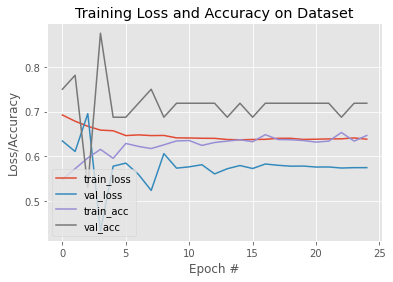

In [39]:
plot_history(history)

In [40]:
confusion_matrix(pred_Y_bin, valY)

array([[772, 112],
       [372, 174]])

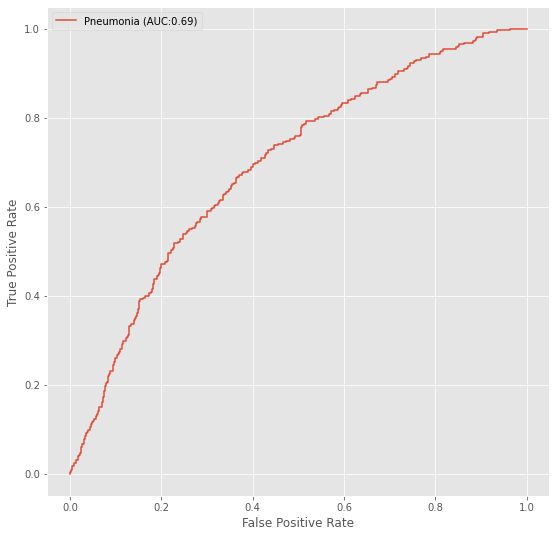

In [41]:
## plot figures

# Todo
plot_auc(valY,pred_Y)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in true_divide


(array([0.34149254, 0.34050179, 0.34070532, ..., 0.00694444,        nan,
        0.        ]),
 array([0.20590353, 0.20533141, 0.20547945, ..., 0.5       , 0.        ,
        1.        ]),
 array([1.       , 0.9965035, 0.9965035, ..., 0.0034965, 0.       ,
        0.       ]),
 array([0.23065203, 0.23185557, 0.23191914, ..., 0.84634995, 0.8564789 ,
        0.87539625], dtype=float32))

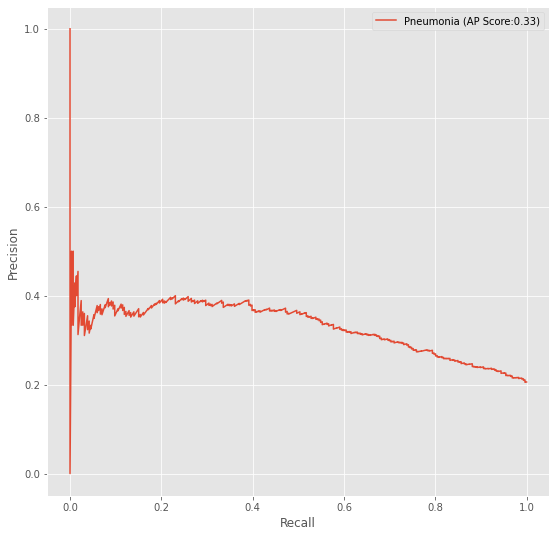

In [42]:
plot_precision_recall_curve(valY,pred_Y)

In [43]:
f1_score(pred_Y_bin, valY)

0.4182692307692308

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in true_divide


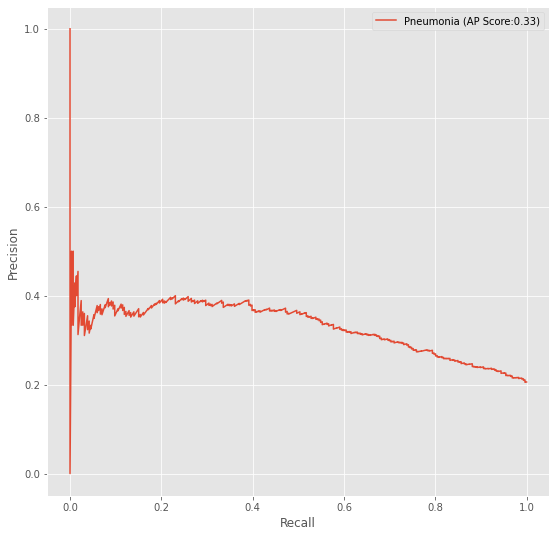

In [44]:
f1, precision, recall, thresholds = plot_precision_recall_curve(valY,pred_Y)#precision_recall_curve(valY,pred_Y)

In [45]:
metrics_df = pd.DataFrame({'f1':f1[:-1], 'prec':precision[:-1], 'recall':recall[:-1], 'thresholds':thresholds})

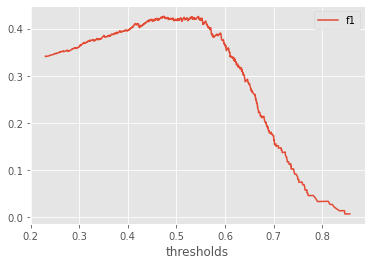

In [46]:
metrics_df.plot(x ='thresholds', y='f1', kind = 'line')
plt.savefig('f1.png')

In [47]:
print('Maximum f1:', metrics_df['f1'].max())
threshold = metrics_df.iloc[metrics_df['f1'].idxmax()]['thresholds']
print('Threshold:', threshold)

Maximum f1: 0.4263392857142857
Threshold: 0.47376856207847595


We select the threshold for which the F1 score is maximized, which is given above. Below, we can also see how the precision and recall vary for different thresholds.

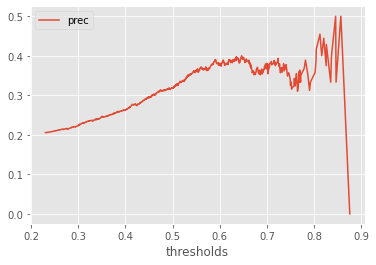

In [48]:
metrics_df.plot(x ='thresholds', y='prec', kind = 'line')

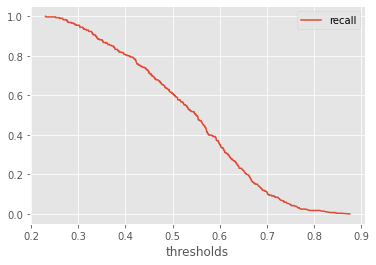

In [49]:
metrics_df.plot(x ='thresholds', y='recall', kind = 'line')

In [50]:
prec = metrics_df.iloc[metrics_df['f1'].idxmax()]['prec']
rec = metrics_df.iloc[metrics_df['f1'].idxmax()]['recall']
print("Precision is {} and recall is {}".format(prec,rec))

Precision is 0.31311475409836065 and recall is 0.6678321678321678


We can see the value of precision and recall for the maximum F1 score presented above. The model chosen with the highest f1 score has a relative high recall and a low precision. This means that there will be many false positives (image recognized as pneumonia while it corresponds to a healthy individuals) and only a few false negatives (image recognized as healthy while it has pneumonia). Since our tool aims to assist radiologists, it is important to having as few false negatives so that we miss as few patients with pneumonia as possible. On the other hand, since further examination will be performed, indidividuals who are healthy may be recognized by the radiologists in their examination.

Once you feel you are done training, you'll need to decide the proper classification threshold that optimizes your model's performance for a given metric (e.g. accuracy, F1, precision, etc.  You decide) 